# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset
## Confidence from Activations + MLP

## 1. Import Libraries

In [1]:
%matplotlib inline
# python libraries
from matplotlib.patches import Rectangle
import natsort as ns
from multiprocessing import cpu_count
from sklearn import metrics
import sys
from sklearn.manifold import TSNE
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras.models import Sequential
from keras.optimizers import Adam

# Meta-Parameters
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package Tree package

# custom libraries
from density_tree.density_forest import *
from density_tree.helpers import print_density_tree_latex
from helpers.helpers import imgs_stretch_eq
from baselines.helpers import *
from baselines.plots import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8093654544661970722
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10967082599
locality {
  bus_id: 2
}
incarnation: 8956569739997086077
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1"
]


In [ ]:
class_to_remove = 2

## 2. Load Images

In [ ]:
path = os.getcwd()

imgs, gt = load_data(path)

# gt to labels
# Next, we need to convert the ground truth (colors) to labels 
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

gt = gt_color_to_label(gt, colors)

### 2.2. Get patches

In [6]:
# Get patches
patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)
print(y_test_nostride.shape)

(3902, 64, 64, 4)
(964, 64, 64, 4)
(964, 64, 64)


## 3. Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [7]:
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [8]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [9]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

classes to keep: ['Buildings', 'Trees', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


### 3.1. Train CNN

In [10]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

<Figure size 432x288 with 0 Axes>

In [11]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)
#model_unet.save('models_out/model_unet_64_flip_rot90_all_cl.h5')  # save model, weights

In [12]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### 3.2. Prediction on Test Set

In [13]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)

# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# get label
y_pred_label = get_y_pred_labels(y_pred, background=True)

# Get accuracy as margin between highest and second highest class
y_pred_acc = get_accuracy_probas(y_pred)
print(np.unique(y_test_nostride))
np.unique(y_pred_label)

3902/3902 [==============================] - 3s 863us/step
[0 1 2 3 4 5 6 7 8]


array([1, 2, 3, 4, 5, 6, 7])

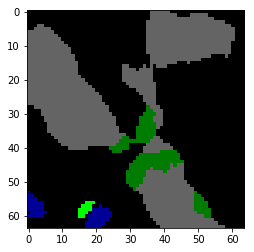

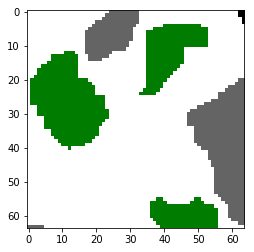

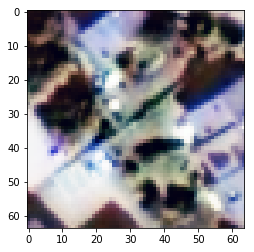

In [14]:
idx=34
plt.imshow(gt_label_to_color(y_pred_label[idx], colors))
plt.show()
plt.imshow(gt_label_to_color(y_test_nostride[idx], colors))
plt.show()
plt.imshow(x_test_nostride[idx][...,:3])

In [15]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[...,np.newaxis],
                                       img_idx=idx_im, img_start=ids_test[0], patch_size=64,
                                       stride=64) for idx_im in ids_test]

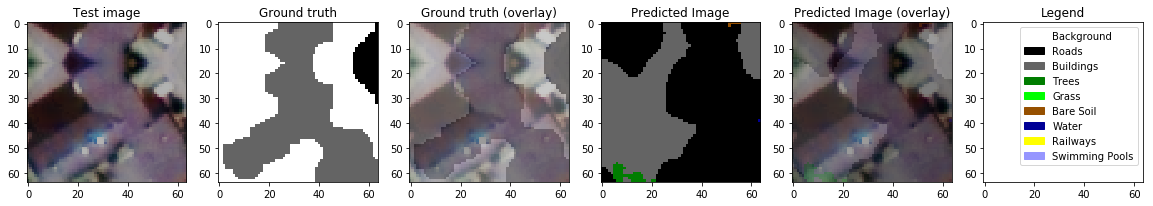

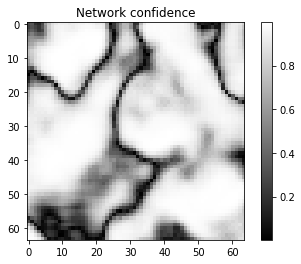

In [16]:
# plot prediction results
im_idx = 15
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_test[im_idx][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_test_label[im_idx], colors)
fig_pred = gt_label_to_color(y_pred_label[im_idx], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = np.asarray([n for n, c in legend_data])
axes[5].legend(handles, labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.title("Network confidence")
plt.colorbar()

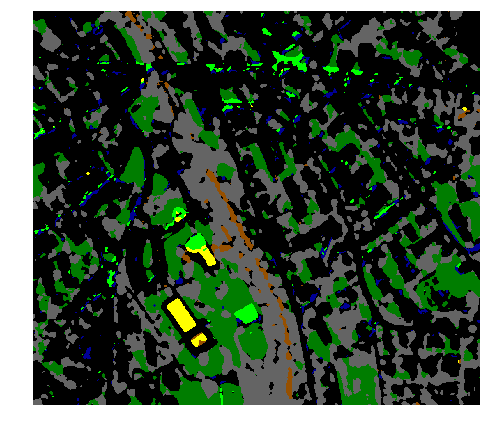

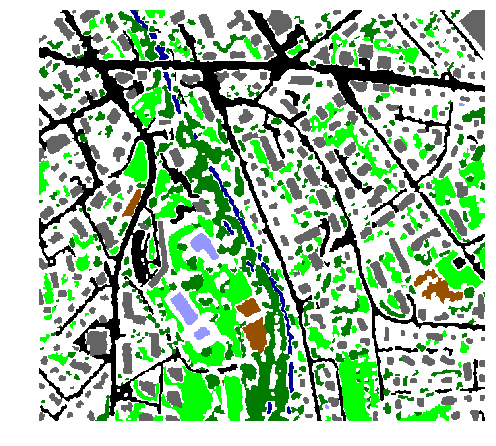

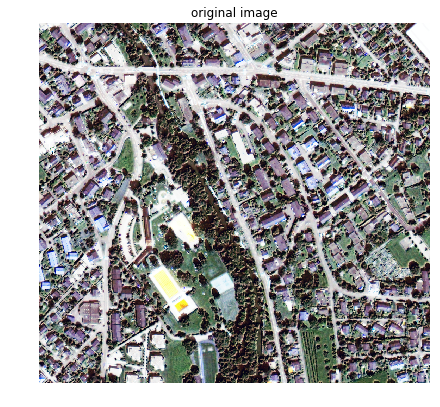

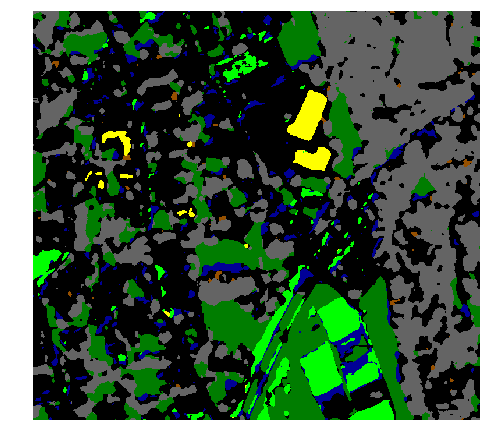

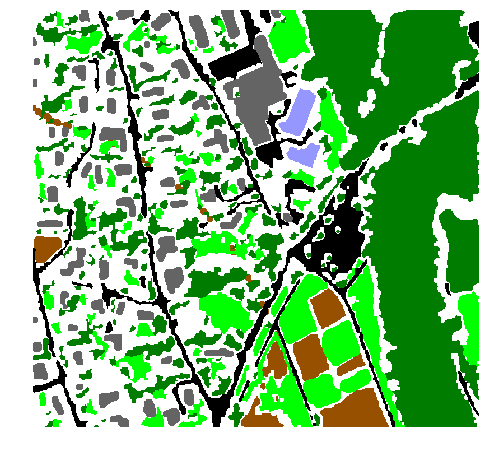

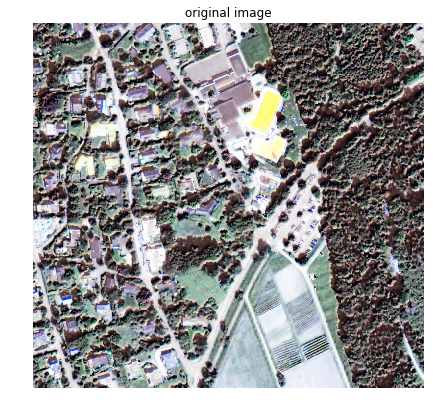

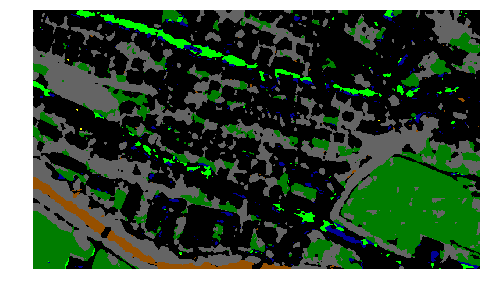

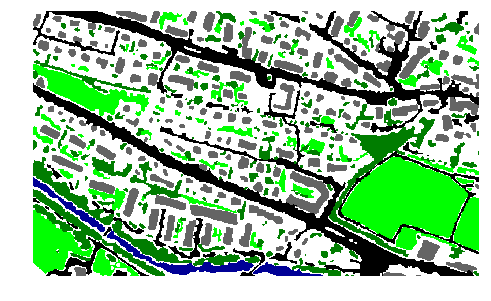

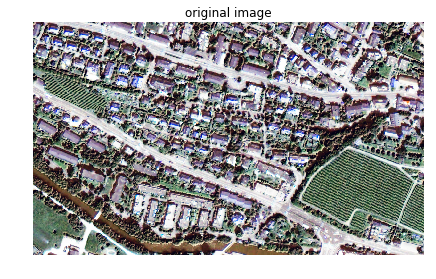

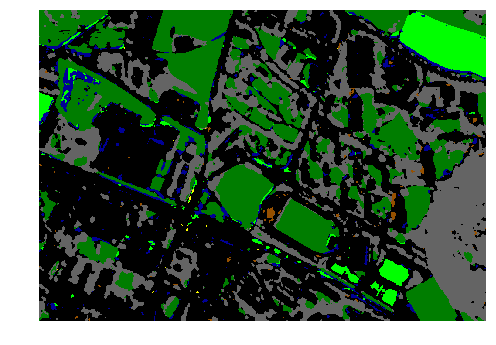

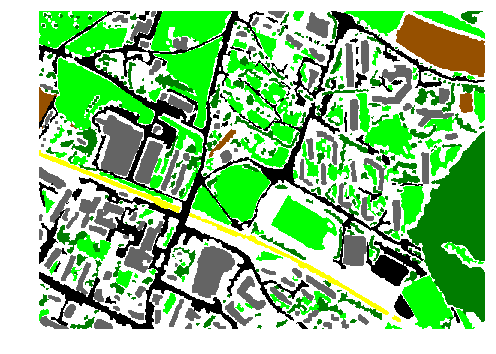

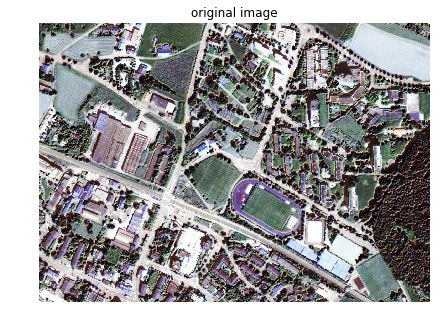

In [17]:
y_pred_im = [convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=16, patch_size=64,
                             stride=64) for i in ids_test]

for img_idx in ids_test:
    # Pred
    plt.figure(figsize=(8,8))
    plt.imshow(y_pred_im[img_idx-16])  # prediction
    plt.axis('off')
    plt.savefig("../Figures/Pred/im_" + str(img_idx+1) + "_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

    # GT
    plt.figure(figsize=(8,8))
    plt.imshow(gt_label_to_color(gt[img_idx],colors))  # gt stitched together
    plt.axis('off')
    plt.savefig("../Figures/Im/gt_" + str(img_idx+1) + ".pdf", bbox_inches='tight', pad_inches=0)


    # show also original image
    plt.figure(figsize=(7, 7))
    plt.imshow(imgs[img_idx][:, :, :3])
    plt.axis('off')
    plt.savefig("../Figures/Im/im_" + str(img_idx+1) + ".pdf", bbox_inches='tight', pad_inches=0)
    plt.title("original image")

### 3.3. Accuracy Metrics (Test Set)

In [18]:
# Accuracy metrics
y_pred_flattened= np.asarray(flatten(flatten(y_pred_label))).astype('int')
y_test_flattened= np.asarray(flatten(flatten(y_test_nostride))).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 8, does not match size of target_names, 7
  .format(len(labels), len(target_names))


                precision    recall  f1-score   support

     Buildings      0.000     0.000     0.000         0
         Trees      0.002     0.002     0.002    470587
         Grass      0.027     0.026     0.027    545015
     Bare Soil      0.048     0.004     0.008    612397
         Water      0.000     0.000     0.000     66093
      Railways      0.000     0.000     0.000     18705
Swimming Pools      0.000     0.000     0.000     18526

   avg / total      0.026     0.010     0.012   1741709

Overall accuracy: 1.031 %


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Get Activations

In [38]:
# image, layer indexes
layer_idx = -2
img_idx = 2
batch_size = 20

# get activations for training Density Forest
act_train = get_activations(imgs, model_unet, layer_idx, x_train, ids_train, batch_size=160, patch_size=64, stride=64)

100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


In [39]:
# get activations for seen classes
# all labels, including background
act_train = np.concatenate(act_train)[(y_train_label != 0) & (y_train_label != class_to_remove)]

In [40]:
# get activations for testing Density Forest
act_test = get_activations(imgs, model_unet, layer_idx, x_test, ids_test, batch_size=160, patch_size=64, stride=32)

# remove test activations overlap
act_test = remove_overlap(imgs, np.concatenate(act_test), ids_test, patch_size=64, stride=32) 

# all labels, including background
act_test = np.concatenate(act_test, axis=0)[y_test_nostride < np.infty] # convert to 1D

100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


In [41]:
# get balanced data subset to show in figure
pts_per_class = 100  # same number of points per class
dataset_subset_indices = []
for class_label in range(1, 9):
    ds_subset_ind = np.where(y_test_nostride[y_test_nostride<np.infty]==class_label)[0]
    dataset_subset_indices.append(np.random.choice(ds_subset_ind, size=pts_per_class, replace=False))

In [42]:
def plot_t_sne(tsne_all, class_to_remove, classes_to_keep, export_tag):
    # plot t-SNE (before PCA)
    fig = plt.figure(figsize=(8, 8))
    for i, class_label in enumerate(classes_to_keep):
        ind_data = np.arange(pts_per_class *(class_label-1),pts_per_class * class_label)
        plt.scatter(tsne_all[ind_data,0], tsne_all[ind_data,1],
                    c=np.asarray(colors)[class_label]/255, marker='o')

    ind_data = np.arange(pts_per_class *(class_to_remove-1), pts_per_class * class_to_remove)
    plt.scatter(tsne_all[ind_data, 0], tsne_all[ind_data, 1],
                c=np.asarray(colors)[class_to_remove]/255, marker='x',)
    names_legend = names_keep.copy()
    names_legend.append('unseen class (' + names[class_to_remove] + ')')
    plt.legend(names_legend)
    plt.axis('off')
    plt.savefig("../Figures/PCA/t-SNE_" + names[class_to_remove] + "_" +
                export_tag + "_PCA.pdf", bbox_inches='tight', pad_inches=0)

In [43]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
#tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

#plot_t_sne(tsne_all, class_to_remove, classes_to_keep, "before")

In [44]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=5)
pca.fit(act_train)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

Variance explained by first 5 components: 0.96


In [45]:
# transform training activations
act_train = pca.transform(act_train)

# transform test set activations
act_test = pca.transform(act_test)

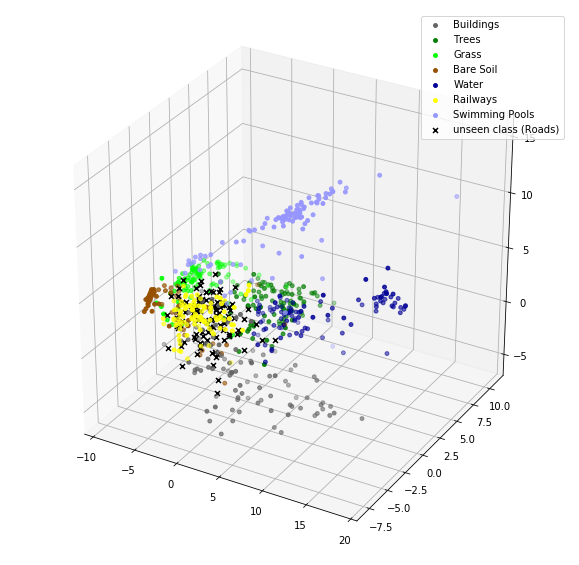

Variance explained by first 3 components: 0.89


In [46]:
# plot PCA point
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=Axes3D.name)

for i, class_keep in enumerate(classes_to_keep):
    ind_data = dataset_subset_indices[class_keep-1]
    plot_data = act_test[ind_data]
    plot_color = np.ones(np.shape(plot_data))*class_keep
    ax.scatter(plot_data[:, 0], plot_data[:, 1], zs=plot_data[:, 2], 
               c=np.asarray(colors)[class_keep]/255, s=15, depthshade=True, marker='o')


ind_data = dataset_subset_indices[class_to_remove-1]
ax.scatter(act_test[ind_data,0], act_test[ind_data,1], zs=act_test[ind_data,2],
           c=np.asarray(colors)[class_to_remove]/255, s=25, marker='x', depthshade=False)


names_legend = names_keep.copy()
names_legend.append('unseen class (' + names[class_to_remove] + ')')
ax.legend(names_legend)
plt.savefig("../Figures/PCA/pca_components_3d_" + names[class_to_remove] + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

# MLP
Train MLP on activations and y_true from training set, evaluate on test set

In [47]:
from keras_helpers.MLP import get_MLP

In [53]:
# get y_train for MLP: correct predictions in training set
y_pred_tr = model_unet.predict(x_train)
y_pred_tr_labels = get_y_pred_labels(y_pred_tr, class_to_remove-1, True) 
y_tr_fl = y_train_label.flatten()
filt = (y_tr_fl!=0) & (y_tr_fl!=class_to_remove)
y_train_MLP = (np.equal(y_pred_tr_labels.flatten()[filt], y_tr_fl[filt] ))

In [50]:
# get y_train for MLP: correct predictions in training set
y_pred_te = model_unet.predict(x_test)
y_pred_te = np.concatenate(remove_overlap(imgs, y_pred_te, ids_test, 64, 32))
y_pred_te_labels = get_y_pred_labels(y_pred_te, class_to_remove-1, True) 
y_test_MLP = (np.equal(y_pred_te_labels.flatten(), y_test_nostride.flatten()))

In [54]:
x_train_MLP = act_train
x_test_MLP = act_test

In [55]:
# convert y to one-hot
num_classes = 2
y_train_MLP = keras.utils.to_categorical(y_train_MLP, num_classes)
y_test_MLP = keras.utils.to_categorical(y_test_MLP, num_classes)

In [56]:
np.shape(x_train_MLP), np.shape(y_train_MLP)

((7002599, 5), (7002599, 2))

In [57]:
np.shape(x_test_MLP), np.shape(y_test_MLP)

((3948544, 5), (3948544, 2))

In [58]:
model_mlp = get_MLP(n_classes=num_classes, input_shape=x_train_MLP.shape[1:], n_filt=70)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 70)                420       
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 70)                4970      
_________________________________________________________________
dropout_4 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 142       
Total params: 5,532
Trainable params: 5,532
Non-trainable params: 0
_________________________________________________________________


In [59]:
batch_size = 5000
epochs = 5

train = True
if train:
    history = model_mlp.fit(x_train_MLP, y_train_MLP,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(x_test_MLP, y_test_MLP))

Train on 7002599 samples, validate on 3948544 samples
Epoch 1/5
7002599/7002599 [==============================] - 11s 2us/step - loss: 0.2264 - acc: 0.9294 - val_loss: 1.5272 - val_acc: 0.3842
Epoch 2/5
7002599/7002599 [==============================] - 11s 2us/step - loss: 0.1943 - acc: 0.9323 - val_loss: 1.5228 - val_acc: 0.3842
Epoch 3/5
7002599/7002599 [==============================] - 10s 1us/step - loss: 0.1882 - acc: 0.9323 - val_loss: 1.5210 - val_acc: 0.3842
Epoch 4/5
7002599/7002599 [==============================] - 11s 2us/step - loss: 0.1852 - acc: 0.9323 - val_loss: 1.5822 - val_acc: 0.3842
Epoch 5/5
7002599/7002599 [==============================] - 11s 2us/step - loss: 0.1835 - acc: 0.9324 - val_loss: 1.5644 - val_acc: 0.3842


In [60]:
y_pred_MLP = model_mlp.predict(x_test_MLP, verbose = 1, batch_size=batch_size)
y_pred_MLP_label = y_pred_MLP[:,1]  # probability to have a good label

3948544/3948544 [==============================] - 1s 0us/step


In [61]:
# get patches from pixels
n_patches = get_offset(imgs, 64, 64, 16, 20)
y_pred_label_patches = np.reshape(y_pred_MLP_label,(n_patches,64, 64))

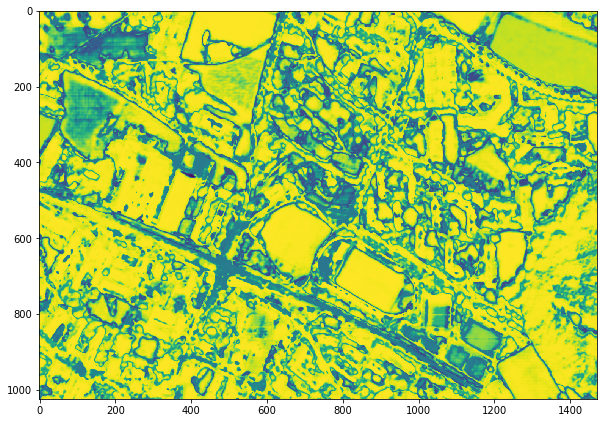

In [62]:

# get image from patches
img_idx = 19
y_pred_label_imgs = convert_patches_to_image(imgs, y_pred_label_patches[..., np.newaxis], img_idx, 64, 64, 16)
plt.figure(figsize=(10,10))
plt.imshow(y_pred_label_imgs[...,0])
plt.savefig("../Figures/baseline/im_" + str(img_idx+1) + "_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

Average certainty unseen class:	0.84657
Average certainty seen classes:	0.75317
Ratio between support-weighted cert. of seen classes / unseen class:	3.925


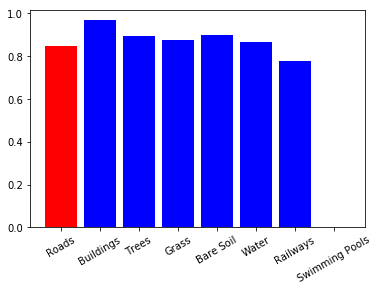

In [63]:
# calculate average certainty by  MLP
av_cert = np.asarray([np.nanmean(y_pred_label_patches
                      [y_test_nostride==label]) 
           for label in np.arange(1, 9)])
av_cert[-1] = 0


plot_probas(av_cert, class_to_remove, names[1:])
plt.savefig("../Figures/baseline/BL1_probas_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

# weighted accuracies
# get support (for weighting)
_, support = np.unique(y_test_nostride, return_counts=True)
support = support[1:]
av_cert_w = (av_cert*support)/sum(support)
cert_unseen_w = av_cert_w[class_to_remove - 1]
cert_seen_w = np.nanmean(np.asarray(av_cert)[av_cert_w != cert_unseen])

print("Average certainty unseen class:\t%.5f" % cert_unseen)
print("Average certainty seen classes:\t%.5f" % cert_seen)
print("Ratio between support-weighted cert. of seen classes / unseen class:\t%.3f" % (cert_seen_w / cert_unseen_w))

In [64]:
# certainty within correctly / wrongly predicted regions
tf = np.asarray((y_pred_label[y_test_nostride!=0]==y_test_nostride[y_test_nostride!=0])*1)

probas = y_pred_label_patches[y_test_nostride!=0]  # probas to have a right prediction in regions wo. bg

# mean certitude in regions predicted incorrectly and regions predicted acorrectly
means_cert = [np.mean(probas[tf==i]) for i in range(2)]
print("Wrong preds: %.2f" % means_cert[0])
print("Corr. preds: %.2f" % means_cert[1])
print("Ratio preds: %.2f" % (means_cert[1]/means_cert[0]))

Wrong preds: 0.90
Corr. preds: 0.86
Ratio preds: 0.96
